# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Análise e Previsão de Séries Temporais com Inteligência Artificial</font>

## <font color='blue'>Estudo de Caso 1</font>
### <font color='blue'>Previsão de Demanda de Produtos ao Longo do Tempo Para Otimizar Decisões de Logística</font>
### <font color='blue'>Parte 2 - Facebook Prophet</font>

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
!pip install -q pystan

In [4]:
!pip install -q prophet

In [5]:
# Imports
import sklearn
import pandas as pd
import numpy as np
import datetime
import requests
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import prophet
from prophet import Prophet

In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

statsmodels: 0.13.2
numpy      : 1.21.5
pandas     : 1.4.4
sklearn    : 1.2.2
requests   : 2.28.1
prophet    : 1.0.1
matplotlib : 3.7.1



## Carregando os Dados

In [19]:
# Carrega o dataset
dados = pd.read_csv('vc_st_dia_fb.csv', sep=';', index_col='data')
dados.head(10)

,acessos
data,
01/06/2022,74
02/06/2022,129
03/06/2022,189
04/06/2022,196
05/06/2022,74
06/06/2022,61
07/06/2022,66
08/06/2022,93
09/06/2022,204


In [8]:
dados.tail(3)

,acessos
data,
26/02/2023,253
27/02/2023,233
28/02/2023,244


In [9]:
dados.index = pd.to_datetime(dados.index, format='%d/%m/%Y')
dados.index

DatetimeIndex(['2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04',
               '2022-06-05', '2022-06-06', '2022-06-07', '2022-06-08',
               '2022-06-09', '2022-06-10',
               ...
               '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22',
               '2023-02-23', '2023-02-24', '2023-02-25', '2023-02-26',
               '2023-02-27', '2023-02-28'],
              dtype='datetime64[ns]', name='data', length=273, freq=None)

In [10]:
# Determinando a frequência como "diária"
dados_ts = dados.asfreq('D')
dados_ts.index

DatetimeIndex(['2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04',
               '2022-06-05', '2022-06-06', '2022-06-07', '2022-06-08',
               '2022-06-09', '2022-06-10',
               ...
               '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22',
               '2023-02-23', '2023-02-24', '2023-02-25', '2023-02-26',
               '2023-02-27', '2023-02-28'],
              dtype='datetime64[ns]', name='data', length=273, freq='D')

In [11]:
dados_ts.describe()

,acessos
count,273.000000
mean,166.996337
std,111.178794
min,49.000000
25%,111.000000
50%,151.000000
75%,200.000000
max,1543.000000


## Estacionarização da Série e Preparação dos Dados

Mesma técnica usada na Parte 1.

In [13]:
# Diferenciação
first_diff = dados_ts.acessos - dados_ts.acessos.shift(1)
first_diff = first_diff.dropna()

O Prophet impõe a condição estrita de que as colunas de entrada **devem** ser nomeadas **ds** e **y**.

In [14]:
# Ajusta os nomes das colunas conforme requerido pelo Prophet
first_diff = pd.DataFrame(data = {'ds': first_diff.index, 'y': first_diff.values})

In [15]:
# Data limite
cutoff_date = '2023-01-01'

In [16]:
# Prepara datasets de treino e teste
amostra_treino = first_diff.loc[first_diff.ds < cutoff_date]
amostra_teste = first_diff.loc[first_diff.ds >= cutoff_date]

In [17]:
amostra_treino.head()

,ds,y
0,2022-06-02,55.0
1,2022-06-03,60.0
2,2022-06-04,7.0
3,2022-06-05,-122.0
4,2022-06-06,-13.0


In [18]:
amostra_teste.head()

,ds,y
213,2023-01-01,-1.0
214,2023-01-02,0.0
215,2023-01-03,14.0
216,2023-01-04,57.0
217,2023-01-05,-83.0


## Modelo Facebook Prophet

* O Facebook Prophet é uma biblioteca de código aberto projetada para fazer previsões de séries temporais univariadas. Neste estudo de caso, a variável que estamos tentando prever é o número de itens vendidos.
* O Prophet encontra automaticamente os hiperparâmetros ideais para o modelo.
* O Prophet decompõe a série temporal em tendência, sazonalidade e efeito de feriado.

**Como o Prophet Funciona:**

A entrada para o modelo Prophet é sempre um dataframe com duas colunas:

* ds - carimbo de data em um formato esperado pelos pandas.
* y - valor numérico. Este é o valor que queremos prever


O Prophet gera um modelo de regressão aditivo com quatro componentes principais:

$$y(t) = g(t) + s(t) + h(t)$$

Tendência $g(t)$

* $g(t)$ é a função de tendência. Esta função modela a mudança não periódica no valor da série temporal.

Sazonalidade $s(t)$

* $s(t)$ é a função de sazonalidade (sazonalidade semanal e anual). Esta função modela as mudanças periódicas.

Holiday $h(t)$

* $h(t)$ é a função de feriados. Esta função modela os efeitos dos feriados que ocorrem em horários potencialmente irregulares durante um ou mais dias.

Previsão $y(t)$

* $y(t)$ é exatamente a previsão do modelo.

In [20]:
# Cria o modelo
modelo = Prophet()

In [21]:
# Treina o modelo
modelo.fit(amostra_treino)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\mfran\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [22]:
amostra_teste.shape

(59, 2)

In [23]:
# Prepara os dados de teste para as previsões
futuro = modelo.make_future_dataframe(periods = amostra_teste.shape[0])

In [24]:
# Previsões
previsoes_do_profeta = modelo.predict(futuro)

C:\Users\mfran\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\mfran\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [25]:
previsoes_do_profeta.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-06-02,2.151730,-182.822812,220.061178,2.151730,2.151730,5.059532,5.059532,5.059532,5.059532,5.059532,5.059532,0.0,0.0,0.0,7.211262
1,2022-06-03,2.131629,-187.983202,189.818683,2.131629,2.131629,1.673834,1.673834,1.673834,1.673834,1.673834,1.673834,0.0,0.0,0.0,3.805463
2,2022-06-04,2.111529,-181.864778,215.130358,2.111529,2.111529,21.889024,21.889024,21.889024,21.889024,21.889024,21.889024,0.0,0.0,0.0,24.000553
3,2022-06-05,2.091428,-223.435089,177.909002,2.091428,2.091428,-13.216653,-13.216653,-13.216653,-13.216653,-13.216653,-13.216653,0.0,0.0,0.0,-11.125225
4,2022-06-06,2.071328,-198.265718,183.108272,2.071328,2.071328,-12.688017,-12.688017,-12.688017,-12.688017,-12.688017,-12.688017,0.0,0.0,0.0,-10.616689


Prophet retorna um grande dataframe que consiste em muitas colunas. As colunas importantes são:

* ds - datestamp
* yhat - valor previsto
* yhat_lower - limite inferior da previsão
* yhat_upper - limite superior da previsão

## Avaliação do Modelo

Usaremos o Erro Absoluto Médio (MAE) e o Erro Quadrático Médio (MSE) para avaliar o modelo.

In [26]:
# Definimos a coluna ds como índice nas previsões
previsoes_do_profeta = previsoes_do_profeta.set_index('ds')

In [27]:
# Definimos a coluna ds como índice nos dados teste
amostra_teste = amostra_teste.set_index('ds')

In [28]:
# Extraímos as previsões que usaremos para avaliar o modelo
previsoes = previsoes_do_profeta.yhat.loc[previsoes_do_profeta.index >= cutoff_date]

In [29]:
print('Prophet MAE = ', mean_absolute_error(previsoes, amostra_teste))

Prophet MAE =  52.846743506497404


In [30]:
print('Prophet MSE = ', mean_squared_error(previsoes, amostra_teste))

Prophet MSE =  4836.390449775512


In [31]:
# Prepara os dados para o Plot
amostra_teste.index = pd.to_datetime(amostra_teste.index)

In [32]:
# Prepara os dados para o Plot
previsoes.index = pd.to_datetime(previsoes.index)

Text(0.5, 1.0, 'Previsões Finais do Profeta')

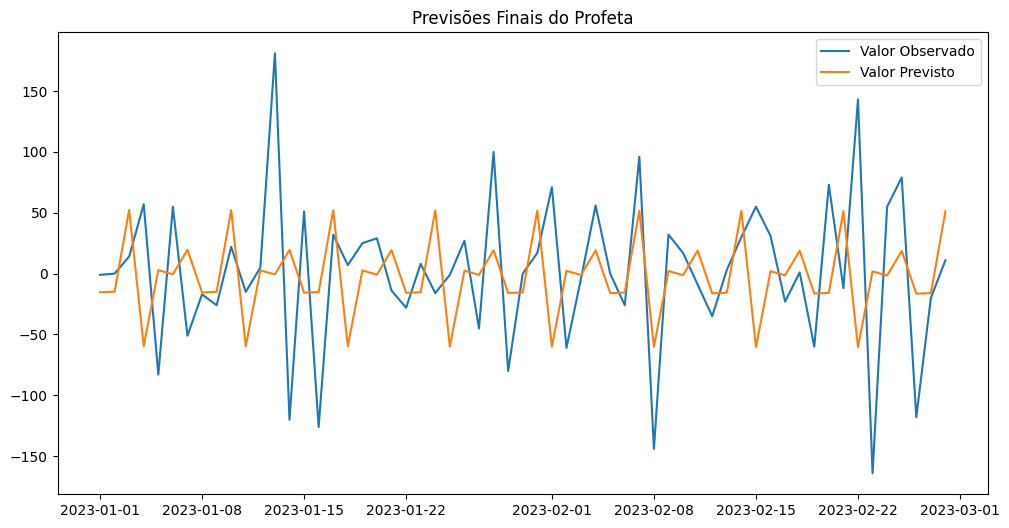

In [33]:
# Plot
fig = plt.figure(figsize = (12,6))
sales = plt.plot(amostra_teste[cutoff_date:], label = 'Valor Observado')
forecast = plt.plot(previsoes, label = 'Valor Previsto')
plt.legend(loc = 'best')
plt.title("Previsões Finais do Profeta")